<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/AbdelMahm/FSR/blob/master/IDDLO-29-20/Notebooks/PCA.ipynb"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" />Run in Google Colab</a>
  </td>
</table>

# Dimensionality Reduction

In [1]:
import sys
import sklearn
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import urllib.request
from sklearn import preprocessing
from sklearn import pipeline

### Load Data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
X = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

### PCA components

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [5]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf.head()

,PC1,PC2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa


### Visualization

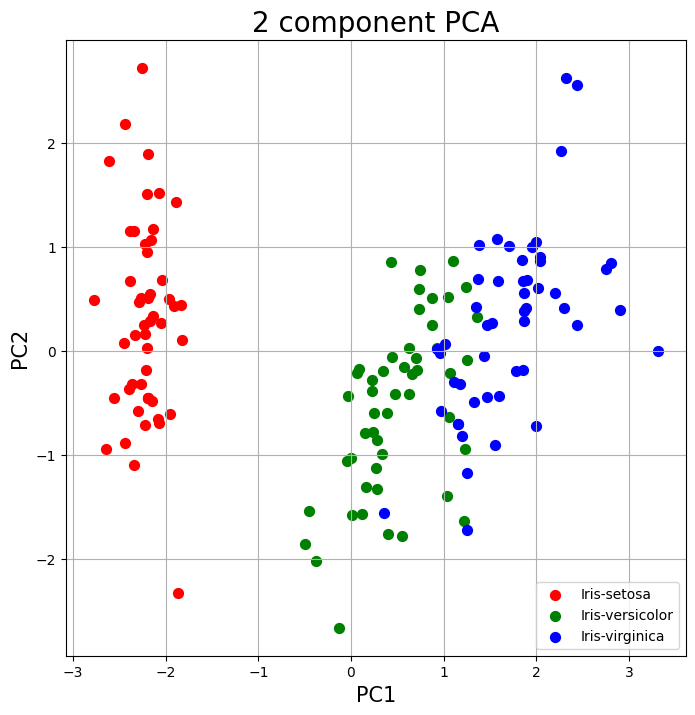

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [7]:
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

## PCA to speed up ML model

In [8]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=6/7, test_size=10000)

### Apply Logistic Regression without PCA

In [10]:
%%time
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9192
CPU times: user 43.9 s, sys: 136 ms, total: 44.1 s
Wall time: 31 s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Apply Logistic Regression after PCA

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In [12]:
from sklearn.decomposition import PCA
# Make an instance of the Model (retain 95% of the variance)
pca = PCA(.95)
pca.fit(X_train)
pca.n_components_

np.int64(154)

In [13]:
X_train_scale_pca = pca.transform(X_train_scale)
X_test_scale_pca = pca.transform(X_test_scale)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [14]:
%%time
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train_scale_pca, y_train)
score_pca = logisticRegr.score(X_test_scale_pca, y_test)
print(score_pca)

0.8761
CPU times: user 18.1 s, sys: 21.2 ms, total: 18.1 s
Wall time: 10.2 s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Return to Original Space (5% missed)

In [15]:
lower_dimensional_data = pca.fit_transform(X_train) # fit and transform in the same time

In [16]:
approximation = pca.inverse_transform(lower_dimensional_data)

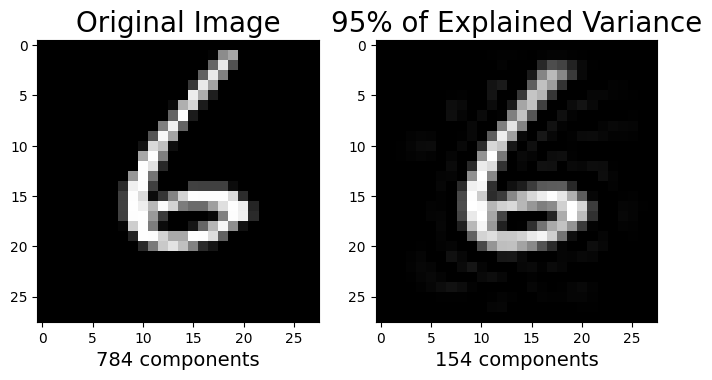

In [17]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_train.iloc[2].values.reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[2].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

#Exercise
1) Compare PCA to kPCA. Use sklearn documentation.

### Comparison of PCA and kPCA

Both PCA (Principal Component Analysis) and kPCA (Kernel PCA) are dimensionality reduction techniques available in scikit-learn, but they differ in their approach:

**PCA (sklearn.decomposition.PCA)**

*   **Linear:** PCA is a linear dimensionality reduction technique. It finds a set of orthogonal linear combinations of the original features that capture the maximum variance in the data.
*   **Assumptions:** Assumes that the principal components are linear combinations of the original features.
*   **Computation:** Based on the eigendecomposition of the covariance matrix or singular value decomposition (SVD) of the data.
*   **Use Cases:** Effective for linearly separable data or when linear relationships among features are dominant. Can be used for noise reduction, visualization, and feature extraction.

**kPCA (sklearn.decomposition.KernelPCA)**

*   **Non-linear:** kPCA is a non-linear dimensionality reduction technique. It uses the "kernel trick" to implicitly map the data into a higher-dimensional feature space where it can perform linear PCA.
*   **Assumptions:** Does not assume linear relationships. Can capture non-linear structures in the data.
*   **Computation:** Based on the eigendecomposition of the kernel matrix, which is computed from the pairwise similarities between data points in the original space.
*   **Use Cases:** Useful when the data has non-linear relationships and cannot be effectively separated or visualized using linear methods. Can reveal hidden non-linear structures.

**Key Differences Summarized:**

| Feature         | PCA                               | kPCA                                  |
|-----------------|-----------------------------------|---------------------------------------|
| Linearity       | Linear                            | Non-linear                            |
| Relationship    | Assumes linear relationships      | Captures non-linear relationships     |
| Computation     | Eigendecomposition of covariance  | Eigendecomposition of kernel matrix   |
| Data Structure  | Best for linearly separable data  | Best for non-linearly separable data  |

In essence, if your data has a complex, non-linear structure, kPCA is likely to be more effective at capturing the underlying patterns than linear PCA. However, kPCA can be more computationally expensive, especially for large datasets, due to the computation of the kernel matrix.